## Simulate The Two Stock Paths Using Multivariate


Simulate the stock prices which we will use later on to estimate the parameters of the multivariate heston model


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from matplotlib import style
from scipy.optimize import NonlinearConstraint
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import plotly.graph_objs as go

In [3]:
np.random.seed(2024)
# Our initial guess of the parameters
True_params = np.array([0.03, 0.03, 3, 3, 0.02, 0.02, 0.1, 0.1, 0.3, -0.3, 0.2])

mu    = np.array([0.03, 0.03])
kappa = np.array([3, 3])
theta = np.array([0.02, 0.02])
xi    = np.array([0.1, 0.1])
rho_sv1 = 0.3
rho_sv2 = -0.3
rho_ss  = 0.2


T = 1                           # Time horizon, say one year
n = 365                         # Number of time steps, divide the time horizon n times (These are trading days)
dt = T / n                      # Time increment

# Initialize variables
S = np.zeros((2, n+1))          # Stock prices, to store the two stock prices
V = np.zeros((2, n+1))          # Volatilities, to store the two volatilities

# Our initial guess of stock prices and volatilities
S[:, 0] = [100, 100]            # Initial stock prices
V[:, 0] = [0.2, 0.2]            # Initial volatilities

# Generate independent standard normal random variables (uncorrelated)
Z = np.random.randn(4, n)

# Calculate correlation matrix
corr_matrix = np.array([[1       , rho_ss  , rho_sv1,  0     ],
                        [rho_ss  , 1       , 0      , rho_sv2],
                        [rho_sv1 , 0       , 1      , 0      ],
                        [0       , rho_sv2 , 0      , 1     ]])

# Generate correlated random variables using the correlation matrix
C = np.linalg.cholesky(corr_matrix) # to obtain the lower traingular of the correlation matrix
Z_correlated = np.dot(C, Z)         # getting a vector of elements correlated using our corr_matrix

# Simulate stock prices and volatilities, making use of Euler discretisation.
for i in range(n):
    dS = mu * S[:, i] * dt + np.sqrt(V[:, i]) * S[:, i] * np.sqrt(dt) * Z_correlated[1:3, i]         # Change in price
    dV = kappa * (theta - V[:, i]) * dt + xi * np.sqrt(V[:, i]) * np.sqrt(dt) * Z_correlated[3:, i]  # Change in volatility

    S[:, i+1] = S[:, i] + dS
    V[:, i+1] = V[:, i] + dV


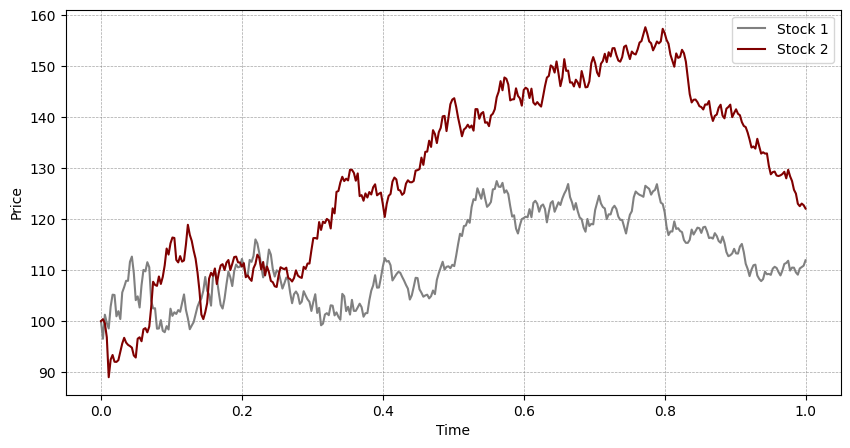

In [4]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(np.linspace(0, T, n+1), S[0], label='Stock 1', color='grey')
ax.plot(np.linspace(0, T, n+1), S[1], label='Stock 2', color='maroon')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.savefig("theTwoStocks.png", bbox_inches='tight')
plt.show()

## Simulate Future Stock Prices

In [5]:
# The Prices for both stocks at T = 1
S1 = S[0, -1]
S2 = S[1, -1]

In [6]:
num_simulations = 1            # Number of simulations
num_prices      = 100          # Number of Paths to Simulate for each stock
np.random.seed(10)
# Initialize matrices to store the simulated prices after T = 1
S1_sim = np.zeros((num_simulations, num_prices, n+1))
S2_sim = np.zeros((num_simulations, num_prices, n+1))

# Initialize variables
SSim = np.zeros((num_prices, n+1, 2))  # Stock prices, to store the two stock prices
VSim = np.zeros((num_prices, n+1, 2))  # Volatilities, to store the two volatilities

# Our initial guess of stock prices and volatilities
SSim[:, 0, 0] = np.tile(S1.flatten(), num_prices)  # Assign initial prices for the first stock
SSim[:, 0, 1] = np.tile(S2.flatten(), num_prices)  # Assign initial prices for the second stock
VSim[:, 0, :] = [0.02, 0.02]                                       # Initial volatilities

# Generate independent standard normal random variables (uncorrelated)
Z = np.random.randn(n, 4, num_prices)  # Transposed Z

# Generate correlated random variables using the correlation matrix
C = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition of correlation matrix
Z_correlated = np.matmul(C, Z)       # Matrix multiplication to get correlated random variables

# Simulate the prices
for sim in range(num_simulations):
    # Simulate stock prices and volatilities, making use of Euler discretisation.
    for i in range(n):
        # print("Wait :) - it's coming", i)  # Print time step, let's see if my code is running
        dS = mu * SSim[:, i, :] * dt + np.sqrt(VSim[:, i, :]) * SSim[:, i, :] * np.sqrt(dt) * Z_correlated[i, 1:3, :].T  # Transpose Z_correlated
        dV = kappa * (theta - VSim[:, i, :]) * dt + xi * np.sqrt(VSim[:, i, :]) * np.sqrt(dt) * Z_correlated[i, 3:, :].T  # Transpose Z_correlated

        SSim[:, i+1, :] = SSim[:, i, :] + dS
        VSim[:, i+1, :] = VSim[:, i, :] + dV
    S2_sim[sim] = SSim[:, :, 1]
    S1_sim[sim] = SSim[:, :, 0]  # Only storing the stock prices, not the volatilities


##### Plotting The Simulated Prices After T = 1

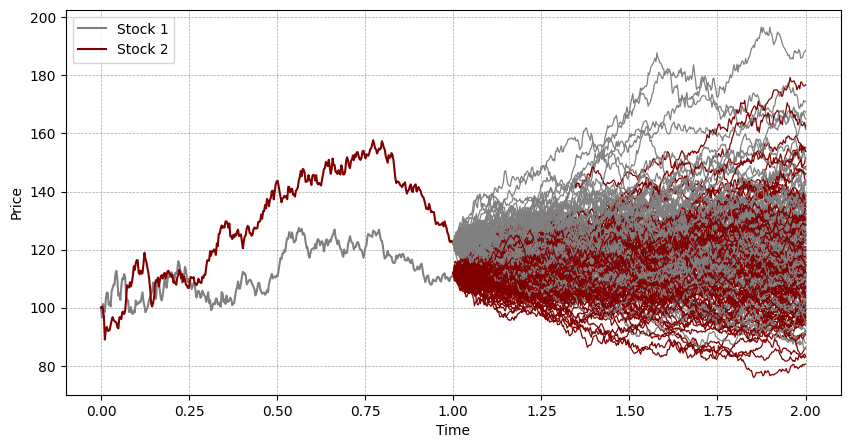

In [7]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 5))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

T2 = 2
ax.plot(np.linspace(0, T, n+1), S[0], label='Stock 1', color='grey')
ax.plot(np.linspace(0, T, n+1), S[1], label='Stock 2', color='maroon')

for sim in range(num_simulations):
    for i in range(num_prices):
        ax.plot(np.linspace(1, T2, n+1), S2_sim[sim, i], color = 'grey', linewidth = 0.9)  # Simulated Stock 2
        ax.plot(np.linspace(1, T2, n+1), S1_sim[sim, i], color = 'maroon', linewidth = 0.9)  # Simulated Stock 1

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.savefig("stock_prices_simulation.png", bbox_inches='tight')
plt.show()


##### Looking at the Simulation of the Stock prices after T = 1 closely

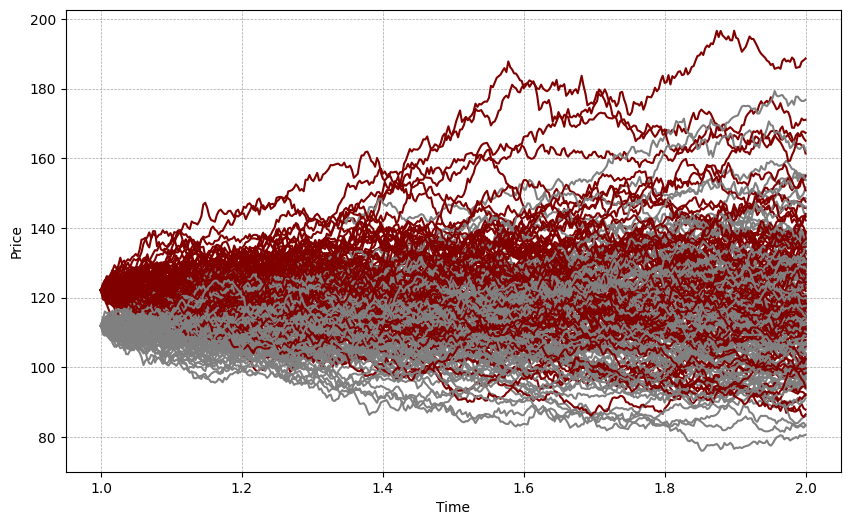

In [8]:
T2 = 2
plt.style.use('default')

plt.figure(figsize=(10, 6))
for sim in range(num_simulations):
    for i in range(num_prices):
        # print("Wait :) - it's coming")
        plt.plot(np.linspace(1, T2, n+1), S1_sim[sim, i], color = 'grey')   # Simulated Stock 1
        plt.plot(np.linspace(1, T2, n+1), S2_sim[sim, i], color = 'maroon')   # Simulated Stock 2

# plt.title('Heston Price Paths Simulation For The Two Stocks')
plt.xlabel('Time')
plt.ylabel('Price')
ax = plt.gca()
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
plt.savefig("simulations.png")
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.show()

##### Histogram of the Payoffs

In [9]:
# The simulated stock prices at T = 2 for both stocks
S1_T2      = S1_sim[:, :, -1]
S2_T2      = S2_sim[:, :, -1]
difference = S1_T2[0] - S2_T2[0]         # Difference between the two stock at T = 2
payoffs    = np.maximum(difference, 0)   # Payoffs for Party II

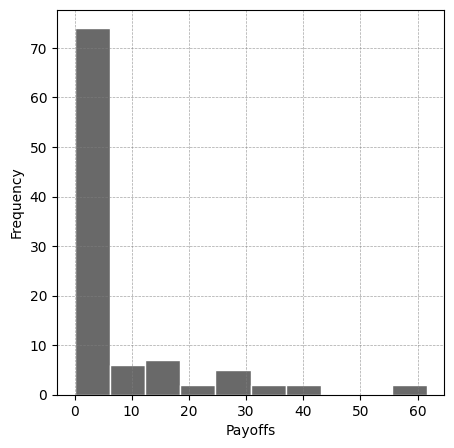

In [10]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(5, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.hist(payoffs, color="dimgray", edgecolor='white')

ax.set_xlabel('Payoffs')
ax.set_ylabel('Frequency')

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')

ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.savefig("payoffs.png", bbox_inches='tight')
plt.show()


In [ ]:
s1 = np.linspace(np.min(S1_T2[0]), np.max(S1_T2[0]), 500)
s2 = np.linspace(np.min(S2_T2[0]), np.max(S2_T2[0]), 500)

ST1, ST2 = np.meshgrid(s1, s2)
difference = ST1 - ST2
payoffs    = np.maximum(difference, 0)

In [ ]:
# Define s1 and s2
s1 = np.linspace(np.min(S1_T2[0]), np.max(S1_T2[0]), 500)
s2 = np.linspace(np.min(S2_T2[0]), np.max(S2_T2[0]), 500)

ST1, ST2 = np.meshgrid(s1, s2)
difference = ST1 - ST2
payoffs = np.maximum(difference, 0)

fig = plt.figure(figsize=(10, 10))
contours = go.Contour(x=ST1.flatten(), y=ST2.flatten(), z=payoffs.flatten(), colorscale='Greys')
surface = go.Surface(x=ST1, y=ST2, z=payoffs, colorscale='Greys')
layout = go.Layout(scene=dict(xaxis=dict(title = 'S1'),yaxis=dict(title = 'S2'),zaxis=dict(title='Payoffs')))
fig = go.Figure(data=[surface], layout=layout)
fig.write_html("PayoffSurface.html")
fig.show()

## MLE of Multivariate Heston

In [ ]:
X = pd.DataFrame(np.array((S[0, ], S[1, ], V[0, ], V[1, ])).T, columns = ['S1', 'S2', 'V1', 'V2'])
X.head()

,S1,S2,V1,V2
0,100.000000,100.000000,0.200000,0.200000
1,96.550388,100.391777,0.197802,0.197802
2,101.270499,99.604768,0.195709,0.195709
3,99.673810,96.860738,0.194573,0.194573
4,98.568636,89.011422,0.193003,0.193003


In [ ]:
from scipy.optimize import minimize, NonlinearConstraint

def log_likelihood(params, X, dt):
    """
    Calculates the log-likelihood for a multivariate stochastic model.
    Args:
      params: Vector of the parameters (11 in total)
      X:      Data frame containing the two stocks (S1, S2) and the volatilities (V1, V2)
      dt:     Time step
    Returns:
      The negative log-likelihood
    """
    mu1, mu2, k1, k2, theta1, theta2, xi1, xi2, rho_ss, rho_sv1, rho_sv2 = params
    S1 = X["S1"]
    S2 = X["S2"]
    V1 = X["V1"]
    V2 = X["V2"]
    n = len(X) - 1

    log_likelihood_val = 0

    for t in range(1, n + 1):
        mt = np.array([
            S1[t - 1] + mu1 * S1[t - 1] * dt,
            S2[t - 1] + mu2 * S2[t - 1] * dt,
            V1[t - 1] + k1 * (theta1 - V1[t - 1]) * dt,
            V2[t - 1] + k2 * (theta2 - V2[t - 1]) * dt
        ])

        sigmat = np.array([
            [(V1[t-1]*S1[t-1])**2*dt, V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0],
            [V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, (V2[t-1]*S2[t-1])**2*dt, 0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt],
            [V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0, (xi1*V1[t-1])**2*dt, 0],
            [0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt, 0, (xi2*V2[t-1])**2*dt]
        ])

        xt = np.array(X.iloc[t, :])
        try:
            term = np.dot((xt - mt).T, np.linalg.solve(sigmat, xt - mt))
            log_likelihood_val += -2 * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigmat)) - 0.5 * term
        except np.linalg.LinAlgError:
            # Might experience numerical issues with the covariance matrix here!
            return np.inf

    return log_likelihood_val

# Contrainst 1. Feller Condition 2. Cov Matrix should be PD 3. The bounds on the Parameters
def feller_condition(params):
    """
    Ensure Feller condition 2k_i * theta_i > xi_i^2 for i = 1, 2.
    """
    _, _, k1, k2, theta1, theta2, xi1, xi2, _, _, _ = params
    return np.array([2 * k1 * theta1 - xi1**2, 2 * k2 * theta2 - xi2**2])

def covariance_positive_definite(params, X, dt):
    """
    Ensure covariance matrix is positive definite by checking the eigenvalues for all time steps.
    """
    mu1, mu2, k1, k2, theta1, theta2, xi1, xi2, rho_ss, rho_sv1, rho_sv2 = params
    S1 = X["S1"]
    S2 = X["S2"]
    V1 = X["V1"]
    V2 = X["V2"]
    n = len(X) - 1

    eigenvalues_list = []

    for t in range(1, n + 1):
        sigmat = np.array([
            [(V1[t-1]*S1[t-1])**2*dt, V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0],
            [V1[t-1]*V2[t-1]*S1[t-1]*S2[t-1]*rho_ss*dt, (V2[t-1]*S2[t-1])**2*dt, 0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt],
            [V1[t-1]*S1[t-1]*xi1*rho_sv1*dt, 0, (xi1*V1[t-1])**2*dt, 0],
            [0, V2[t-1]*S2[t-1]*xi2*rho_sv2*dt, 0, (xi2*V2[t-1])**2*dt]
        ])
        eigenvalues = np.linalg.eigvals(sigmat)
        eigenvalues_list.extend(eigenvalues)

    return np.array(eigenvalues_list) - 1e-6

bounds = [(0, 1),            # mu1
          (0, 1),            # mu2
          (0, 5),            # k1 (lower bound: 0)
          (0, 5),            # k2 (lower bound: 0)
          (0, 1),            # theta1 (no bounds)
          (0, 1),            # theta2 (no bounds)
          (0.00001, 1),      # xi1 (lower bound: 0)
          (0.00001, 1),      # xi2 (lower bound: 0)
          (-0.95, 0.95),     # rho_ss (bounds between -1 and 1 for correlation)
          (-0.95, 0.95),     # rho_sv1 (bounds between -1 and 1 for correlation)
          (-0.95, 0.95)]     # rho_sv2 (bounds between -1 and 1 for correlation)

initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])

# Our initial guess should satisfy constraints
while np.any(feller_condition(initial_guess) < 0) or np.any(covariance_positive_definite(initial_guess, X, dt) < 0):
    initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])

print(initial_guess)

cov_constraint = NonlinearConstraint(lambda params: covariance_positive_definite(params, X, dt), 0, np.inf)
feller_constraint = NonlinearConstraint(feller_condition, 0, np.inf)

# Check whether the initial guess statisfy the constraints
print("Initial guess satisfies Feller condition:", feller_condition(initial_guess))
print("Initial guess satisfies covariance positive definiteness:", np.all(covariance_positive_definite(initial_guess, X, dt) > 0))

result = minimize(lambda params: -log_likelihood(params, X, dt),
                  initial_guess,
                  method='SLSQP',
                  bounds=bounds,
                  constraints=[cov_constraint, feller_constraint])
print(result)

[ 6.43615781e-01  6.67646539e-01  4.23973329e+00  4.69233809e+00
  8.72627861e-01  4.03054127e-01  9.56241171e-01  9.67529685e-01
 -1.40847621e-01 -8.96279888e-03  1.44973178e-03]
Initial guess satisfies Feller condition: [6.48502162 2.84641878]
Initial guess satisfies covariance positive definiteness: True


<ipython-input-117-817b168a98c6>:40: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: -5903114346.907381
       x: [ 0.000e+00  0.000e+00  0.000e+00  5.000e+00  1.000e+00
            0.000e+00  1.000e-05  1.000e-05  9.500e-01 -9.500e-01
           -9.500e-01]
     nit: 17
     jac: [-2.046e+05  3.213e+05  1.155e+08  4.930e+07 -0.000e+00
            1.243e+09  6.042e+14  5.742e+14 -2.596e+09 -6.518e+09
           -6.200e+09]
    nfev: 233
    njev: 17


In [ ]:
# Do the True Parameters satisfy the constraints
print(np.all(covariance_positive_definite(True_params, X, dt)))
print(np.all(feller_condition(True_params) > 0))

True
True


In [ ]:
print("Initial Parameters: ", np.round(initial_guess, decimals = 3))
print("Estimated Parameters: ", np.round(result.x, decimals = 3))
print("True Parameters: ", True_params)

NameError: name 'np' is not defined

# Neural Network Application